## Environment setup

In [55]:
import os
project_name = "recobase"; branch = "US987772"; account = "recohut"
project_path = os.path.join('/content', branch)

In [6]:
import os
project_name = "reco-us"; branch = "us987772"; account = "sparsh-ai"
project_path = os.path.join('/content', project_name)

In [ ]:
if not os.path.exists(project_path):
    !pip install -U -q dvc dvc[gdrive]
    !cp -r /content/drive/MyDrive/git_credentials/. ~
    !mkdir "{project_path}"
    %cd "{project_path}"
    !git init
    !git remote add origin https://github.com/"{account}"/"{project_name}".git
    !git pull origin "{branch}"
    !git checkout -b "{branch}"
else:
    %cd "{project_path}"

In [ ]:
!dvc pull

In [ ]:
!git status

In [ ]:
!git add . && git commit -m 'commit' && git push origin "{branch}"

In [ ]:
!pip install icecream
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html

## Development

Graph Matching based Collaborative Filtering (GMCF)

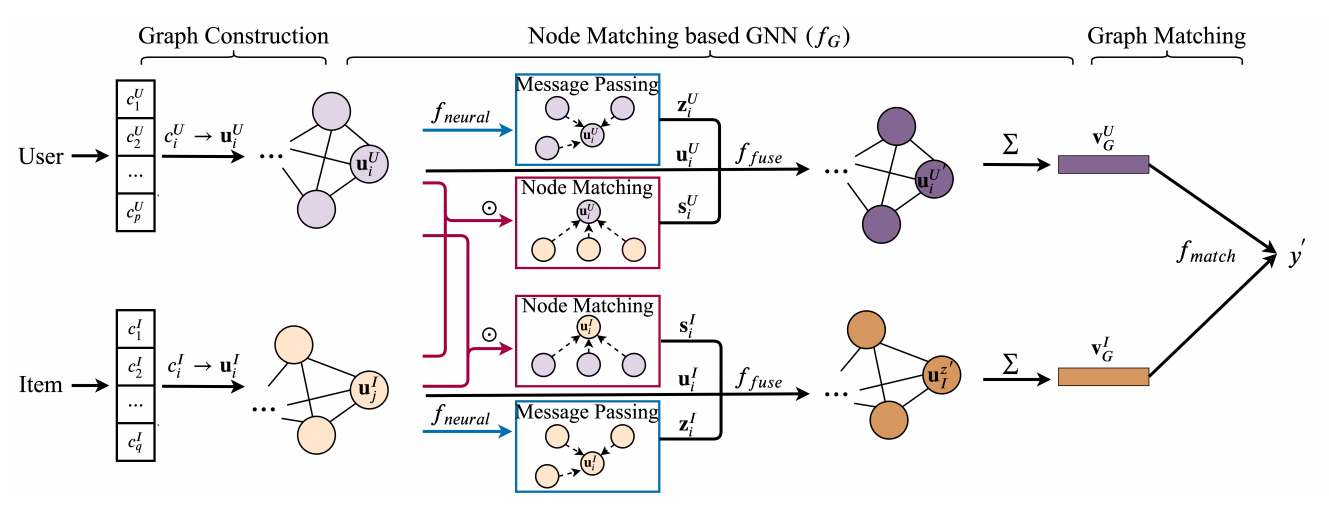

In [ ]:
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, ndcg_score
from sklearn.utils import shuffle

import pickle
import argparse
from icecream import ic

import torch
from torch import Tensor
import torch.nn as nn 
from torch.nn import Linear
from torch.nn import Parameter 
import torch.nn.functional as F

from torch_geometric.data import InMemoryDataset, Data, Dataset, DataLoader
from torch_geometric.utils import to_undirected
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.utils import softmax, add_self_loops
from torch_geometric.nn.inits import glorot, zeros

import warnings
warnings.filterwarnings('ignore')

## Data transformation

### Special instructions

Each dataset folder contains four files:

```
/
├── feature_dict.pkl       --> (A dictionary that contains all attribute name with corresponding feature index)
├── implicit_ratings.csv   --> (A csv file containing ratings of each data sample)
├── item_dict.pkl          --> (A dictionary containing the attributes of each item)
├── user_dict.pkl          --> (A dictionary containing the attributes of each user)
```

To run the code on datasets, generate files using the following format:

```
feature_dict.pkl:
Format: {attributeName: index}
```

```
implicit_ratings.csv
Format: user_id, item_id, rating
```

```
item_dict.pkl
Format: item_id: {'title': item index, 'attribute': a list of attributes}  
```

```
user_dict.pkl
Format: item_id: {'name': user index, 'attribute': a list of attributes}  
```

### Author's approach

MovieLens 1M contains users’ ratings on movies. Each data sample contains a user and a movie with their corresponding attributes. We further collect movies’ other attributes, such as directors and casts from IMDB to enrich the datasets. Book-crossing contains users’ implicit and explicit ratings of books. Each data sample contains a user and a book with their corresponding attributes. The reprocessed words in the book titles are also regarded as attributes of the book. Taobao is a dataset that collects the log of click on display advertisement displayed on the website of Taobao. Each log contains a user with corresponding attributes such as gender and age level, a displayed advertisement with attributes such as category and brand of the advertised item.

MovieLens 1M and Book-crossing contain explicit ratings. We transfer the explicit ratings to implicit feedback. We regard the ratings greater than 3 as positive ratings for MovieLens 1M and regard all rated explicit ratings as positive ratings for Book-crossing due to its sparsity. Then, we randomly select the same number of negative samples equal to the number of positive samples for each user. To ensure the datasets’ quality, we select the users with more than 10 positive ratings for MovieLens 1M and have more than 20 positive ratings for Book-crossing and Taobao.

## EDA

```
implicit_ratings.csv
Format: user_id, item_id, rating
```

In [ ]:
ratings = pd.read_csv('ml-1m/implicit_ratings.csv', header=None)
ratings.head()

,0,1,2
0,1,1193,1
1,1,3408,1
2,1,2355,1
3,1,1287,1
4,1,2804,1


```
item_dict.pkl
Format: item_id: {'title': item index, 'attribute': a list of attributes}  
```

In [ ]:
items = pd.DataFrame.from_dict(pd.read_pickle('ml-1m/item_dict.pkl'), orient='index')
items.head()

,title,attribute
1,1,"[9147, 9148, 9149, 9150, 9151, 9152, 9153, 915..."
2,2,"[9156, 9157, 9158, 9159, 9151, 9160, 9153, 916..."
3,3,"[9162, 9163, 9164, 9165, 9151, 9154, 9166, 9155]"
4,4,"[9167, 9168, 9169, 9170, 9151, 9154, 9171, 916..."
5,5,"[9172, 9173, 9174, 9175, 9151, 9154, 9161, 916..."


```
user_dict.pkl
Format: user_id: {'name': user index, 'attribute': a list of attributes} 
```

In [ ]:
users = pd.DataFrame.from_dict(pd.read_pickle('ml-1m/user_dict.pkl'), orient='index')
users.head()

,name,attribute
1,3113,"[15196, 15197, 15198]"
2,3114,"[15199, 15200, 15201]"
3,3115,"[15199, 15202, 15203]"
4,3116,"[15199, 15204, 15205]"
5,3117,"[15199, 15202, 15206]"


In [ ]:
dict(list(pd.read_pickle('ml-1m/feature_dict.pkl').items())[0:5]), \
dict(list(pd.read_pickle('ml-1m/feature_dict.pkl').items())[-5:])

({'1_Toy Story': 1,
  '2_Jumanji': 2,
  '3_Grumpier Old Men': 3,
  '4_Waiting to Exhale': 4,
  'unkown': 0},
 {'occ_13': 15224,
  'occ_18': 15222,
  'occ_2': 15221,
  'occ_5': 15223,
  'occ_6': 15225})

## PyTorch Dataset

In [ ]:
class Dataset(InMemoryDataset):
    def __init__(self, root, dataset, transform=None, pre_transform=None):
        self.path = root
        self.dataset = dataset
        self.store_backup = True
        super(Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.stat_info = torch.load(self.processed_paths[1])
        self.data_num = self.stat_info['data_num']
        self.feature_num = self.stat_info['feature_num']
        self.raw_dir = '{}'.format(self.dataset)
    @property
    def raw_file_names(self):
        return ['{}/user_dict.pkl'.format(self.dataset),
                '{}/item_dict.pkl'.format(self.dataset),
                '{}/feature_dict.pkl'.format(self.dataset),
                '{}/implicit_ratings.csv'.format(self.dataset)]
    @property
    def processed_file_names(self):
        return ['{}/{}.dataset'.format(self.dataset, self.dataset),
                '{}/{}.statinfo'.format(self.dataset, self.dataset)]
    def download(self):
        # Download to `self.raw_dir`.
        pass
    def data_2_graphs(self, ratings_df, dataset='train'):
        graphs = []
        processed_graphs = 0
        num_graphs = ratings_df.shape[0]
        one_per = int(num_graphs/1000)
        percent = 0.0
        for i in range(len(ratings_df)):
            if processed_graphs % one_per == 0:
                print(f"Processing [{dataset}]: {percent/10.0}%, {processed_graphs}/{num_graphs}", end="\r")
                percent += 1
            processed_graphs += 1 
            line = ratings_df.iloc[i]
            user_index = self.user_key_type(line[0])
            item_index = self.item_key_type(line[1])
            rating = int(line[2])
            if item_index not in self.item_dict or user_index not in self.user_dict:
                error_num += 1
                continue
            user_id = self.user_dict[user_index]['name']
            item_id = self.item_dict[item_index]['title']
            user_attr_list = self.user_dict[user_index]['attribute']
            item_attr_list = self.item_dict[item_index]['attribute']
            user_list = [user_id] + user_attr_list
            item_list = [item_id] + item_attr_list
            graph = self.construct_graphs(user_list, item_list, rating)
            graphs.append(graph)
        print()
        return graphs
    def read_data(self):
        self.user_dict = pickle.load(open(self.userfile, 'rb'))
        self.item_dict = pickle.load(open(self.itemfile, 'rb'))
        self.user_key_type = type(list(self.user_dict.keys())[0])
        self.item_key_type = type(list(self.item_dict.keys())[0])
        feature_dict = pickle.load(open(self.featurefile, 'rb'))
        data = []
        error_num = 0
        ratings_df = pd.read_csv(self.ratingfile, header=None)
        train_df, test_df = train_test_split(ratings_df, test_size=0.4, random_state=random.randint(0,1000), stratify=ratings_df[[0,2]])
        test_df, valid_df = train_test_split(test_df,  test_size=0.5, random_state=random.randint(0,1000), stratify=test_df[[0,2]])
        # store a backup of train/valid/test dataframe
        if self.store_backup:
            backup_path = f"{self.dataset}/split_data_backup/"
            if not os.path.exists(backup_path):
                os.mkdir(backup_path)
        train_df.to_csv(f'{backup_path}train_data.csv', index=False)
        valid_df.to_csv(f'{backup_path}valid_data.csv', index=False)
        test_df.to_csv(f'{backup_path}test_data.csv', index=False)
        print('(Only run at the first time training the dataset)')
        train_graphs = self.data_2_graphs(train_df, dataset='train')
        valid_graphs = self.data_2_graphs(valid_df, dataset='valid')
        test_graphs = self.data_2_graphs(test_df, dataset='test')
        graphs = train_graphs + valid_graphs + test_graphs 
        stat_info = {}
        stat_info['data_num'] = len(graphs)
        stat_info['feature_num'] = len(feature_dict)
        stat_info['train_test_split_index'] = [len(train_graphs), len(train_graphs) + len(valid_graphs)]
        print('error number of data:', error_num)
        return graphs, stat_info
    def construct_graphs(self, user_list, item_list, rating):
        u_n = len(user_list)   # user node number
        i_n = len(item_list)   # item node number
        # construct full inner edge
        inner_edge_index = [[],[]]
        for i in range(u_n):
            for j in range(i, u_n):
                inner_edge_index[0].append(i)
                inner_edge_index[1].append(j)
        for i in range(u_n, u_n + i_n ):
            for j in range(i, u_n + i_n):
                inner_edge_index[0].append(i)
                inner_edge_index[1].append(j)
        # construct outer edge
        outer_edge_index = [[],[]]
        for i in range(u_n):
            for j in range(i_n):
                outer_edge_index[0].append(i)
                outer_edge_index[1].append(u_n + j)
        #construct graph
        inner_edge_index = torch.LongTensor(inner_edge_index)
        inner_edge_index = to_undirected(inner_edge_index)
        outer_edge_index = torch.LongTensor(outer_edge_index)
        outer_edge_index = to_undirected(outer_edge_index)
        graph = self.construct_graph(user_list + item_list, inner_edge_index, outer_edge_index, rating)
        return graph
    def construct_graph(self, node_list, edge_index_inner, edge_index_outer, rating):
        x = torch.LongTensor(node_list).unsqueeze(1)
        rating = torch.FloatTensor([rating])
        return Data(x=x, edge_index=edge_index_inner, edge_attr=torch.transpose(edge_index_outer, 0, 1), y=rating)
    def process(self):
        self.userfile  = self.raw_file_names[0]
        self.itemfile  = self.raw_file_names[1]
        self.featurefile = self.raw_file_names[2]
        self.ratingfile  = self.raw_file_names[3]
        graphs, stat_info = self.read_data()
        #check whether folder path exist
        if not os.path.exists(f"{self.dataset}/processed"):
            os.mkdir(f"{self.dataset}/processed")
        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(stat_info, self.processed_paths[1])
    def feature_N(self):
        return self.feature_num
    def data_N(self):
        return self.data_num

In [ ]:
dataset = Dataset('./data')

In [ ]:
data_num = dataset.data_N()
feature_num = dataset.feature_N()
train_index, val_index = dataset.stat_info['train_test_split_index']
#print(np.concatenate((dataset[0][0:5], dataset[0][6:10])))
ic(data_num, feature_num)

In [ ]:
# split inner graphs
train_dataset = dataset[:train_index]
val_dataset = dataset[train_index:val_index]
test_dataset = dataset[val_index:]

## Model

In [ ]:
class inner_GNN(MessagePassing):
    def __init__(self, dim, hidden_layer):
        super(inner_GNN, self).__init__(aggr='mean')

        #construct pairwise modeling network
        self.lin1 = nn.Linear(dim, hidden_layer)
        self.lin2 = nn.Linear(hidden_layer, dim)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, edge_weight=None):
        # x has shape [N, dim]
        # edge_index has shape [2, E]
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight):
        # x_i has shape [E, dim]
        # x_j has shape [E, dim]

        # pairwise analysis
        pairwise_analysis = x_i + x_j
        pairwise_analysis = self.lin1(pairwise_analysis)
        pairwise_analysis = self.act(pairwise_analysis)
        pairwise_analysis = self.lin2(pairwise_analysis)
        pairwise_analysis = self.drop(pairwise_analysis)
        #pairwise_analysis = x_i * x_j

        if edge_weight != None:
            interaction_analysis = pairwise_analysis * edge_weight.view(-1,1)
        else:
            interaction_analysis = pairwise_analysis

        return interaction_analysis

    def update(self, aggr_out):
        # aggr_out has shape [N, dim]
        return aggr_out

In [ ]:
class cross_GNN(MessagePassing):
    def __init__(self, dim, hidden_layer):
        super(cross_GNN, self).__init__(aggr='add')

    def forward(self, x, edge_index, edge_weight=None):
        # x has shape [N, dim]
        # edge_index has shape [2, E]
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    #def message(self, edge_index_i, x_i, x_j, edge_weight, num_nodes):
    def message(self, x_i, x_j, edge_weight):
        # x_i has shape [E, dim]
        # x_j has shape [E, dim]

        # pairwise analysis
        pairwise_analysis = x_i * x_j

        if edge_weight != None:
            interaction_analysis = pairwise_analysis * edge_weight.view(-1,1)
        else:
            interaction_analysis = pairwise_analysis

        return interaction_analysis

    def update(self, aggr_out):
        # aggr_out has shape [N, dim]
        return aggr_out

In [ ]:
class GMCF(nn.Module):
    """
    GMCF main model
    """
    def __init__(self, args, n_features, device):
        super(GMCF, self).__init__()

        self.n_features = n_features
        self.dim = args.dim
        self.hidden_layer = args.hidden_layer
        self.device = device
        self.batch_size = args.batch_size
        self.num_user_features = args.num_user_features

        self.feature_embedding = nn.Embedding(self.n_features + 1, self.dim)
        #self.feature_embedding.weight.data.normal_(0.0,0.01)
        self.inner_gnn = inner_GNN(self.dim, self.hidden_layer)
        self.outer_gnn = cross_GNN(self.dim, self.hidden_layer)

        self.node_weight = nn.Embedding(self.n_features + 1, 1)
        self.node_weight.weight.data.normal_(0.0,0.01)
        
        self.update_f = nn.GRU(input_size=self.dim, hidden_size=self.dim, dropout=0.5) 
        self.g = nn.Linear(self.dim, 1, bias=False)


    def forward(self, data, is_training=True):
        # does not conduct link prediction, use all interactions

        node_id = data.x.to(self.device)
        batch = data.batch

        # handle pointwise features
        node_w = torch.squeeze(self.node_weight(node_id))
        sum_weight = global_add_pool(node_w, batch)


        node_emb = self.feature_embedding(node_id)
        inner_edge_index = data.edge_index
        outer_edge_index = torch.transpose(data.edge_attr, 0, 1)


        inner_node_message = self.inner_gnn(node_emb, inner_edge_index)
        outer_node_message = self.outer_gnn(node_emb, outer_edge_index)

        # aggregate all message
        updated_node_input = torch.cat((node_emb, inner_node_message, outer_node_message), 1)
        updated_node_input = torch.transpose(updated_node_input, 0, 1)

        gru_h0 = torch.normal(0, 0.01, (1, node_emb.size(0), self.dim)).to(self.device)
        gru_output, hn = self.update_f(updated_node_input, gru_h0)
        updated_node = gru_output[-1]                     #[batch_size*n_node, dim]


        new_batch = self.split_batch(batch, self.num_user_features)
        updated_graph = torch.squeeze(global_mean_pool(updated_node, new_batch))
        item_graphs, user_graphs = torch.split(updated_graph, int(updated_graph.size(0)/2))

        y = torch.unsqueeze(torch.sum(user_graphs * item_graphs, 1) + sum_weight, 1)
        y = torch.sigmoid(y)

        return y


    def split_batch(self, batch, user_node_num):
        """
        split batch id into user nodes and item nodes 
        """
        ones = torch.ones_like(batch)
        nodes_per_graph = global_add_pool(ones, batch)
        cum_num = torch.cat((torch.LongTensor([0]).to(self.device), torch.cumsum(nodes_per_graph, dim=0)[:-1]))
        cum_num_list = [cum_num + i for i in range(user_node_num)]
        multi_hot = torch.cat(cum_num_list)
        test = torch.sum(F.one_hot(multi_hot, ones.size(0)), dim=0) * (torch.max(batch) + 1 )

        return batch + test

## Train

In [ ]:
def train(args, data_info, show_loss):
    train_loader = data_info['train']
    val_loader= data_info['val']
    test_loader= data_info['test']
    feature_num = data_info['feature_num']
    train_num, val_num, test_num = data_info['data_num']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = 'cpu'
    model = GMCF(args, feature_num, device)
    model = model.to(device)

    optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            weight_decay=args.l2_weight, 
            lr=args.lr
    )
    crit = torch.nn.BCELoss()

    print([i.size() for i in filter(lambda p: p.requires_grad, model.parameters())])
    print('start training...')
    for step in range(args.n_epoch):
        # training
        loss_all = 0
        edge_all = 0
        model.train()
        for data in train_loader:
            data = data.to(device)
            output = model(data)
            label = data.y
            label = label.to(device)
            baseloss = crit(torch.squeeze(output), label)
            loss = baseloss
            loss_all += data.num_graphs * loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        cur_loss = loss_all / train_num 

        # evaluation
        val_auc, val_logloss, val_ndcg5, val_ndcg10 = evaluate(model, val_loader, device)
        #val_auc, val_logloss, val_ndcg5, val_ndcg10 = 0, 0, 0, 0 
        test_auc, test_logloss, test_ndcg5, test_ndcg10 = evaluate(model, test_loader, device)

        print('Epoch: {:03d}, Loss: {:.5f}, AUC: {:.5f}/{:.5f}, Logloss: {:.5f}/{:.5f}, NDCG@5: {:.5f}/{:.5f} NDCG@10: {:.5f}/{:.5f}'.
          format(step, cur_loss, val_auc, test_auc, val_logloss, test_logloss, val_ndcg5, test_ndcg5, val_ndcg10, test_ndcg10))

## Evaluate

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()

    predictions = []
    labels = []
    user_ids = []
    edges_all = [0, 0]
    with torch.no_grad():
        for data in data_loader:
            _, user_id_index = np.unique(data.batch.detach().cpu().numpy(), return_index=True)
            user_id = data.x.detach().cpu().numpy()[user_id_index]
            user_ids.append(user_id)

            data = data.to(device)
            pred = model(data)
            pred = pred.squeeze().detach().cpu().numpy().astype('float64')
            if pred.size == 1:
                pred = np.expand_dims(pred, axis=0)
            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

    predictions = np.concatenate(predictions, 0)
    labels = np.concatenate(labels, 0)
    user_ids = np.concatenate(user_ids, 0)

    ndcg5 = cal_ndcg(predictions, labels, user_ids, 5)
    ndcg10 = cal_ndcg(predictions, labels, user_ids, 10)
    auc = roc_auc_score(labels, predictions)
    logloss = log_loss(labels, predictions)

    return auc, logloss, ndcg5, ndcg10

## Metric

In [ ]:
def cal_ndcg(predicts, labels, user_ids, k):
    d = {'user': np.squeeze(user_ids), 'predict':np.squeeze(predicts), 'label':np.squeeze(labels)}
    df = pd.DataFrame(d)
    user_unique = df.user.unique()

    ndcg = []
    for user_id in user_unique:
        user_srow = df.loc[df['user'] == user_id]
        upred = user_srow['predict'].tolist()
        if len(upred) < 2:
            #print('less than 2', user_id)
            continue
        #supred = [upred] if len(upred)>1 else [upred + [-1]]  # prevent error occured if only one sample for a user
        ulabel = user_srow['label'].tolist()
        #sulabel = [ulabel] if len(ulabel)>1 else [ulabel +[1]]

        ndcg.append(ndcg_score([ulabel], [upred], k=k)) 

    return np.mean(np.array(ndcg))

## Argument parsing

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='ml-1m', help='which dataset to use')
parser.add_argument('--rating_file', type=str, default='implicit_ratings.csv', help='which dataset to use')
parser.add_argument('--dim', type=int, default=64, help='dimension of entity and relation embeddings')
parser.add_argument('--l2_weight', type=float, default=1e-5, help='weight of the l2 regularization term')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--batch_size', type=int, default=1024, help='batch size')
parser.add_argument('--n_epoch', type=int, default=50, help='the number of epochs')
parser.add_argument('--hidden_layer', type=int, default=256, help='neural hidden layer')
parser.add_argument('--num_user_features', type=int, default=3, help='the number of user attributes')
parser.add_argument('--random_seed', type=int, default=2019, help='size of common item be counted')
#random.choice(range(2000))
sep = ','
args = parser.parse_args(args={})

## Dataset build

In [ ]:
#dataset = Dataset_larger('../data/', args.dataset, args.rating_file, sep, 10)
dataset = Dataset('/content/', args.dataset, args.rating_file, sep)

Processing...
(Only run at the first time training the dataset)
Processing [train]: 100.1%, 686686/686843


In [ ]:
data_num = dataset.data_N()
feature_num = dataset.feature_N()
train_index, val_index = dataset.stat_info['train_test_split_index']
#print(np.concatenate((dataset[0][0:5], dataset[0][6:10])))
ic(data_num, feature_num)

## Dataloader

In [ ]:
# split inner graphs
train_dataset = dataset[:train_index]
val_dataset = dataset[train_index:val_index]
test_dataset = dataset[val_index:]

n_workers = 4
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=n_workers)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=n_workers)

## Model training

In [ ]:
show_loss = False
print(f"""
datast: {args.dataset}
vector dim: {args.dim}
batch_size: {args.batch_size}
lr: {args.lr}
""")

datainfo = {}
datainfo['train'] = train_loader
datainfo['val'] = val_loader 
datainfo['test'] = test_loader
datainfo['feature_num'] = feature_num 
datainfo['data_num'] = [len(train_dataset), len(val_dataset), len(test_dataset)]

train(args, datainfo, show_loss)